In [1]:
import os,sys
from google.colab import drive

drive.mount('/content/MyDrive')
os.chdir('/content/MyDrive/MyDrive/LiDAR_Project')
sys.path.append(os.getcwd())

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [2]:
!pip install torch-geometric
!pip install torch-cluster

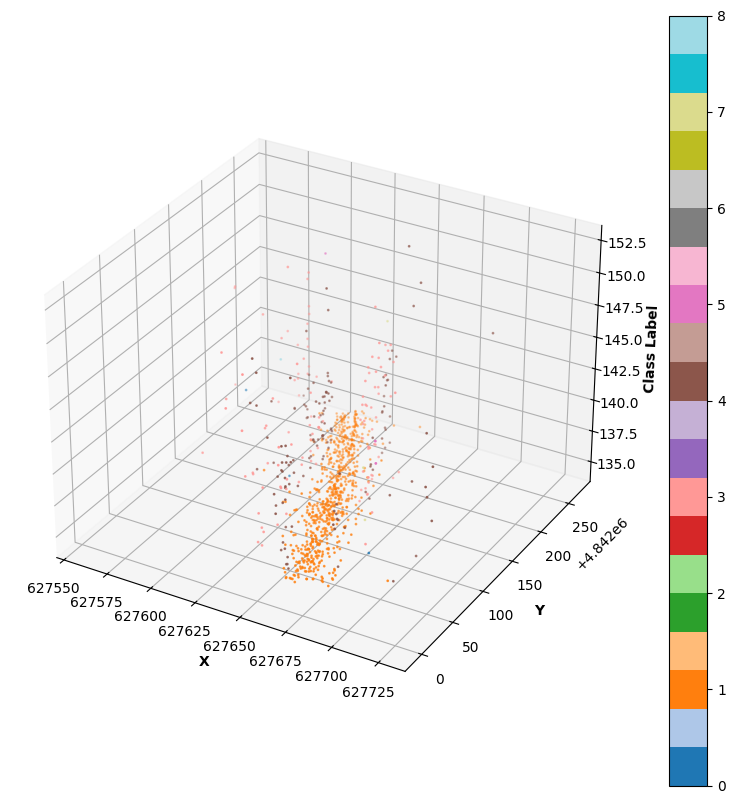

Saved visualization: Results/test_0.png


In [4]:
import torch
from torch_geometric.loader import DataLoader
from dataset import LiDARSegDataset
from models.point_transformer_seg import PointTransformerSeg
from utils import visualize_pointcloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------
# Load Test Dataset
# -------------------------

test_dataset = LiDARSegDataset(root='/content/MyDrive/MyDrive/LiDAR_Project/NPZ_LiDAR', split='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# -------------------------
# Load Trained Model
# -------------------------

model = torch.load('/content/MyDrive/MyDrive/LiDAR_Project/point_transformer_full_model.pth', map_location=device, weights_only=False)
model = model.to(device)
model.eval()

# -----------------------
# Evaluate & visualize
# -----------------------
for idx,data in enumerate(test_loader):
  data = data.to(device)

  # Forward path
  with torch.no_grad():
    out = model(data.x, data.pos, data.batch) #[num_points, num_classes]
    preds = out.argmax(dim=1)

  pos = data.pos.cpu().numpy()
  preds = preds.cpu().numpy()

  # Save visualizations
  os.makedirs('Results', exist_ok=True)
  save_path = f'Results/test_{idx}.png'
  visualize_pointcloud(pos, preds, save_path)

  print(f'Saved visualization: {save_path}')


Overall Accuracy: 0.6738

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.77      0.99      0.87       579
           2       0.00      0.00      0.00        48
           3       0.66      0.44      0.53       189
           4       0.23      0.46      0.31        69
           5       0.33      0.22      0.27         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        33
           8       0.00      0.00      0.00         1

    accuracy                           0.67      1024
   macro avg       0.22      0.24      0.22      1024
weighted avg       0.58      0.67      0.61      1024



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


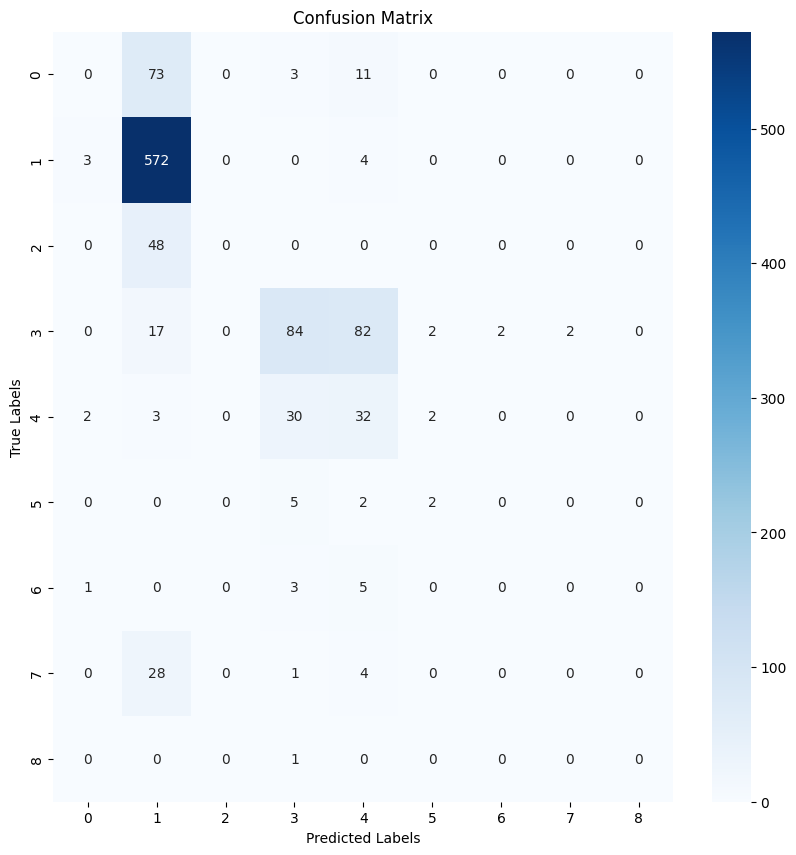

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
  for data in test_loader:
    data = data.to(device)
    out = model(data.x, data.pos, data.batch)
    preds = out.argmax(dim=1).cpu().numpy()
    labels = data.y.cpu().numpy()

    all_preds.append(preds)
    all_labels.append(labels)
# Flatten lists
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute metrics
overall_acc = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {overall_acc:.4f}\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds))


cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()